In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import mlflow
import mlflow.pytorch
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

### Challenge:

- predizer o valor de fechamento da bolsa de valores de uma empresa 
- pipeline de desenvolvimento:
    - criação do modelo preditivo
    - deploy do modelo em uma API que permita a previsão de preços de ações

In [2]:
# Set device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

### Dados históricos:

- techfase4\process\get_data.ipynb
- tensorer não aceitam string nem datas

In [3]:
df0 = pd.read_pickle("dados.pkl")
df0["Date"] = pd.to_datetime(df0["Date"])
df0["Timestamp"] = df0["Date"].astype("int64") // 10**9  # segundos desde 1970
df0["Year"] = df0["Date"].dt.year
df0["Month"] = df0["Date"].dt.month
df0["Day"] = df0["Date"].dt.day
df0["WeekDay"] = df0["Date"].dt.weekday

In [4]:
df = df0.sort_values("Date")
df = df.drop(columns=["Date"])

In [5]:
df.head()

,Close,High,Low,Open,Ticker,Volume,Timestamp,Year,Month,Day,WeekDay
0,137.391541,137.623750,136.444877,137.087896,ACN,3061900,1514851200,2018,1,2,1
1,138.025620,138.418577,136.632416,136.632416,ACN,2064200,1514937600,2018,1,3,2
2,139.659958,140.088633,138.222097,138.427502,ACN,1777000,1515024000,2018,1,4,3
3,140.812057,140.856714,139.436719,139.865394,ACN,1597600,1515110400,2018,1,5,4
4,141.937332,142.008780,140.070796,140.544128,ACN,2616900,1515369600,2018,1,8,0


### Inspecionando os dados para definição da janela temporal

In [6]:
df.describe()

,Close,High,Low,Open,Volume,Timestamp,Year,Month,Day,WeekDay
count,1873.000000,1873.000000,1873.000000,1873.000000,1.873000e+03,1.873000e+03,1873.000000,1873.000000,1873.000000,1873.000000
mean,249.629985,251.959652,247.217214,249.504800,2.300837e+06,1.632194e+09,2021.237587,6.347571,15.695141,2.026161
std,74.149978,74.860414,73.489809,74.147875,1.082340e+06,6.785369e+07,2.158920,3.434579,8.764150,1.399733
min,121.532257,124.487145,120.586675,122.559629,5.281000e+05,1.514851e+09,2018.000000,1.000000,1.000000,0.000000
25%,174.650208,176.011583,173.041359,174.291186,1.652200e+06,1.573430e+09,2019.000000,3.000000,8.000000,1.000000
50%,265.695068,268.057948,262.927262,264.879462,2.054600e+06,1.632182e+09,2021.000000,6.000000,16.000000,2.000000
75%,308.175201,311.455574,305.912421,308.221585,2.590400e+06,1.690934e+09,2023.000000,9.000000,23.000000,3.000000
max,396.284912,396.384425,391.758116,394.201428,1.490550e+07,1.749773e+09,2025.000000,12.000000,31.000000,4.000000


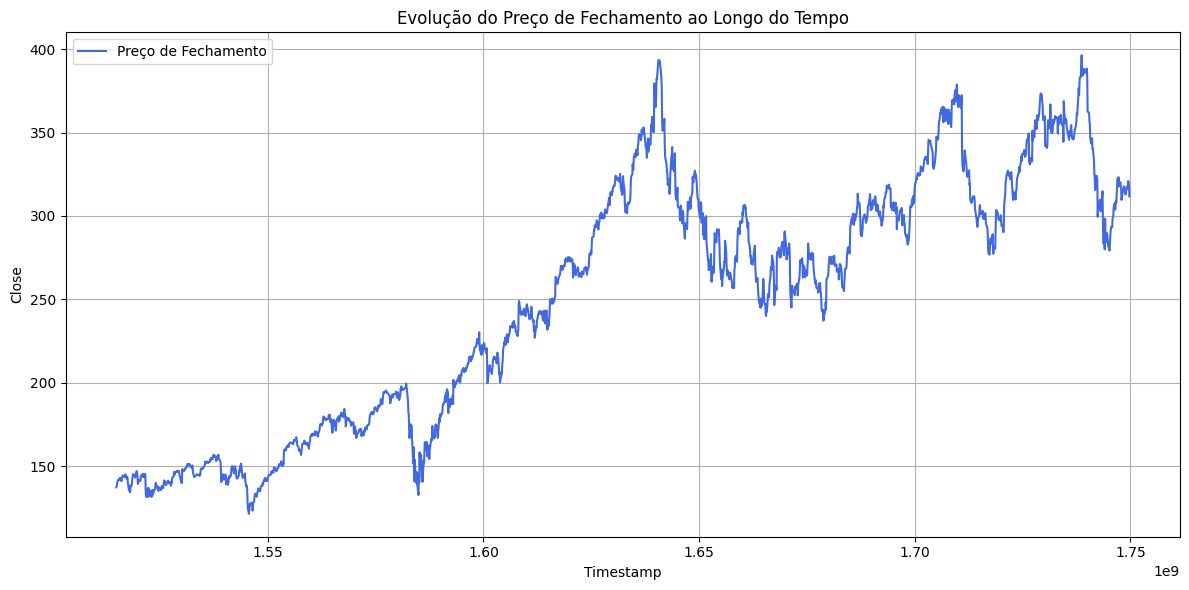

In [7]:
plt.figure(figsize=(12, 6))
plt.plot(df["Timestamp"], df["Close"], label="Preço de Fechamento", color="royalblue")
plt.xlabel("Timestamp")
plt.ylabel("Close")
plt.title("Evolução do Preço de Fechamento ao Longo do Tempo")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


### Normalização dos dados

1. Coluna Ticker, categórica, converter para numérica

In [8]:
df["Ticker"] = LabelEncoder().fit_transform(df["Ticker"])
tickers = df["Ticker"]

2. Colunas numéricas

In [9]:
scaler = MinMaxScaler()

In [10]:
df_num = df.drop(columns=["Ticker"], errors="ignore")

df_scaled = pd.DataFrame(scaler.fit_transform(df_num), columns=df_num.columns)

In [11]:
# Reanexa a coluna Ticker
df_scaled["Ticker"] = tickers.values

In [12]:
df_scaled

,Close,High,Low,Open,Volume,Timestamp,Year,Month,Day,WeekDay,Ticker
0,0.057722,0.048315,0.058480,0.053483,0.176235,0.000000,0.0,0.000000,0.033333,0.25,0
1,0.060030,0.051238,0.059172,0.051806,0.106841,0.000368,0.0,0.000000,0.066667,0.50,0
2,0.065978,0.057380,0.065034,0.058415,0.086865,0.000736,0.0,0.000000,0.100000,0.75,0
3,0.070171,0.060205,0.069513,0.063708,0.074388,0.001103,0.0,0.000000,0.133333,1.00,0
4,0.074267,0.064442,0.071852,0.066207,0.145284,0.002207,0.0,0.000000,0.233333,0.00,0
...,...,...,...,...,...,...,...,...,...,...,...
1868,0.710049,0.716237,0.720774,0.719515,0.122637,0.998529,1.0,0.454545,0.266667,0.00,0
1869,0.725699,0.725284,0.724314,0.717895,0.127144,0.998897,1.0,0.454545,0.300000,0.25,0
1870,0.719512,0.725579,0.727412,0.730228,0.092569,0.999264,1.0,0.454545,0.333333,0.50,0
1871,0.715544,0.713993,0.721032,0.717638,0.115904,0.999632,1.0,0.454545,0.366667,0.75,0


### Criando sequências para LSTM:
- Modelos LSTM (Long Short-Term Memory) não aprendem apenas com os dados atuais, mas com janelas do passado.
- Eles precisam ver os últimos n passos no tempo para prever o próximo valor.
- A função create_sequences cria exatamente essas janelas.
- O tamanho da sequência: quantos passos de tempo o modelo vai olhar de uma vez. Ex: 20 dias passados do dado por input.

In [13]:
def create_sequences(data, sequence_length, target_index):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length][target_index])
    return np.array(X), np.array(y)

# Exemplo de uso:
target_index = df_scaled.columns.get_loc("Close")
data_array = df_scaled.to_numpy()
X_seq, y_seq = create_sequences(data_array, 20, target_index)

### Convertendo para tensores e DataLoader

In [14]:
X_tensor = torch.tensor(X_seq, dtype=torch.float32)
y_tensor = torch.tensor(y_seq, dtype=torch.float32).view(-1, 1)

dataset = TensorDataset(X_tensor, y_tensor)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

In [15]:
# Desnormalização da coluna "Close"
close_index = df_num.columns.get_loc("Close")
scaler_y = MinMaxScaler()
scaler_y.min_ = scaler.min_[close_index:close_index+1]
scaler_y.scale_ = scaler.scale_[close_index:close_index+1]

In [16]:
num_features = X_tensor.shape[2]
print("Number of features:", num_features)

Number of features: 11


### LSTM

In [17]:
# Hyperparameters
input_size = X_tensor.shape[2]      # Number of features in the input data
hidden_size = 50     # Number of hidden units in the LSTM
num_layers = 2       # Number of LSTM layers
output_size = 1      # prever apenas o Close
num_epochs = 50
batch_size = 64
learning_rate = 0.001
sequence_length = 20  # Length of the input sequences
num_samples = 10000  # Number of artificial samples to generate

In [38]:
ativacoes = {
    "ReLU": nn.ReLU(),
    "Tanh": nn.Tanh(),
    "Sem_Ativacao": nn.Identity()
}

In [39]:
class LSTMAtivacao(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, ativacao):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.regressor = nn.Sequential(
            ativacao,
            nn.Linear(hidden_size, output_size)
        )

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.regressor(out[:, -1, :])

In [41]:
def avaliar_modelo(modelo, loader, scaler_y=None):
    modelo.eval()
    preds, reais = [], []
    with torch.no_grad():
        for X_batch, y_batch in loader:
            pred = modelo(X_batch.to(device)).cpu()
            preds.append(pred)
            reais.append(y_batch)

    y_hat = torch.cat(preds).squeeze().numpy().reshape(-1, 1)
    y_true = torch.cat(reais).squeeze().numpy().reshape(-1, 1)

    if scaler_y:
        y_hat = scaler_y.inverse_transform(y_hat).flatten()
        y_true = scaler_y.inverse_transform(y_true).flatten()

    mae = mean_absolute_error(y_true, y_hat)
    r2 = r2_score(y_true, y_hat)

    return y_true, y_hat, mae, r2

Treinando com ativação: ReLU


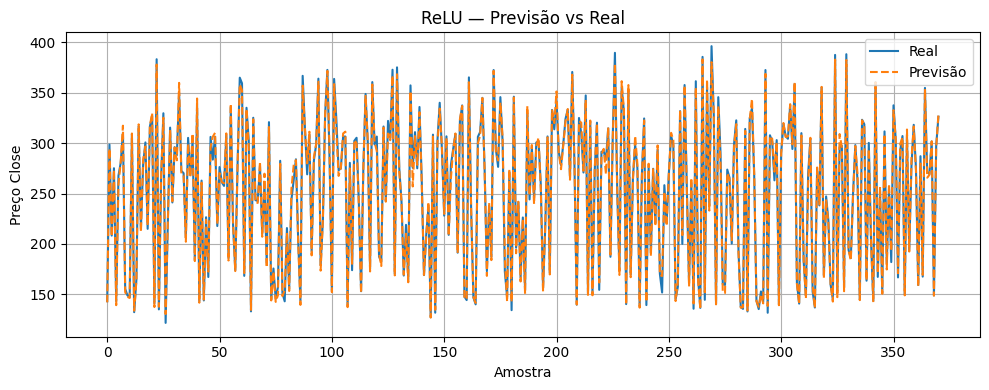

Treinando com ativação: Tanh


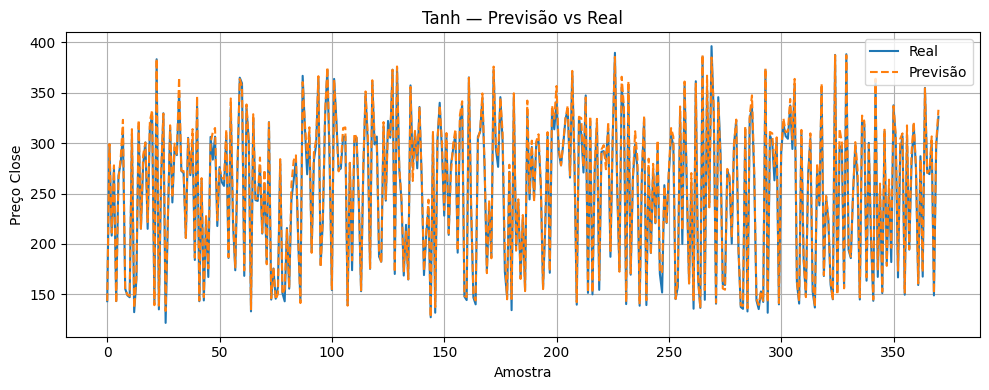

Treinando com ativação: Sem_Ativacao


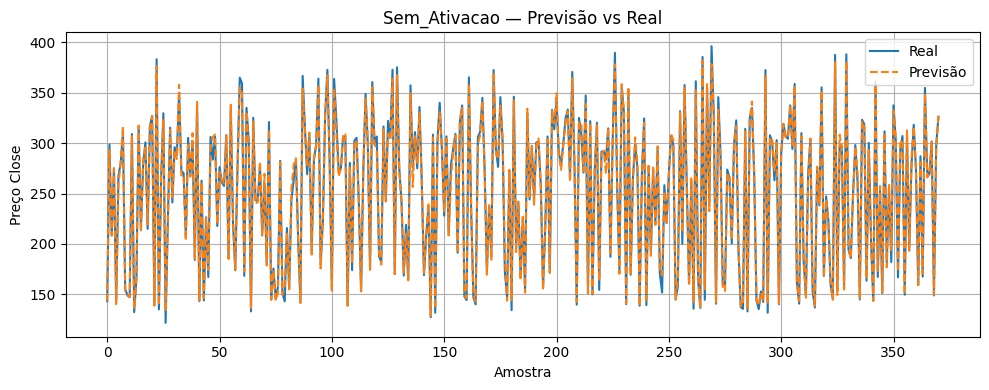

In [46]:
resultados = {}
modelos_salvos = {}

for nome, funcao in ativacoes.items():
    print(f"Treinando com ativação: {nome}")
    
    model = LSTMAtivacao(input_size, hidden_size, num_layers, output_size, funcao).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    loss_fn = nn.MSELoss()

    # Início do experimento no MLflow
    mlflow.set_experiment("LSTM Artificial Data Regression")
    with mlflow.start_run(run_name=f"Ativação: {nome}"):
        # Log dos parâmetros
        mlflow.log_param("activation", nome)
        mlflow.log_param("input_size", input_size)
        mlflow.log_param("hidden_size", hidden_size)
        mlflow.log_param("num_layers", num_layers)
        mlflow.log_param("output_size", output_size)
        mlflow.log_param("num_epochs", num_epochs)
        mlflow.log_param("batch_size", batch_size)
        mlflow.log_param("learning_rate", learning_rate)
        # Treinamento
        for epoch in range(num_epochs):
            model.train()
            for X_batch, y_batch in train_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                pred = model(X_batch)
                loss = loss_fn(pred, y_batch)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        # Avaliação
        y_true, y_pred, mae, r2 = avaliar_modelo(model, test_loader, scaler_y)
        resultados[nome] = {"MAE": mae, "R2": r2}
        modelos_salvos[nome] = model.state_dict()  # Salva na memória

        # Log das métricas
        mlflow.log_metric("MAE", mae)
        mlflow.log_metric("R2", r2)

        # Log do gráfico (opcional — salvar e enviar)
        plt.figure(figsize=(10, 4))
        plt.plot(y_true, label="Real")
        plt.plot(y_pred, linestyle="--", label="Previsão")
        plt.title(f"{nome} — Previsão vs Real")
        plt.xlabel("Amostra")
        plt.ylabel("Preço Close")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()

        plot_path = f"grafico_{nome}.png"
        plt.savefig(plot_path)
        mlflow.log_artifact(plot_path)
        plt.show()

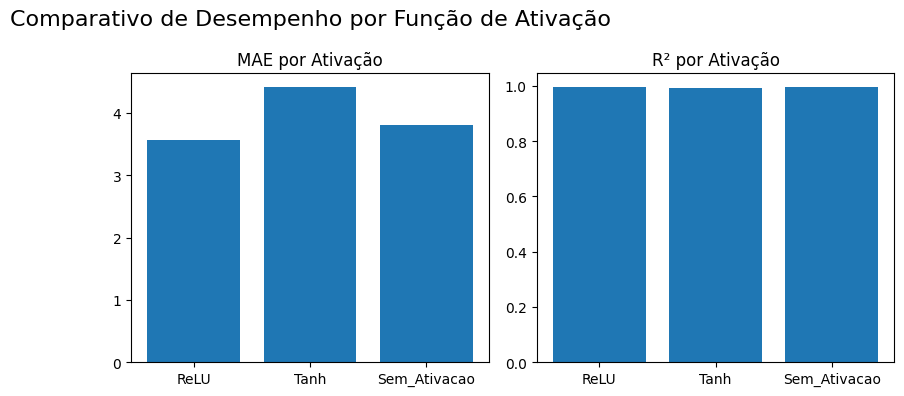

In [47]:
labels = list(resultados.keys())
mae_vals = [resultados[k]["MAE"] for k in labels]
r2_vals  = [resultados[k]["R2"] for k in labels]

x = np.arange(len(labels))

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 2)
plt.bar(x, mae_vals, tick_label=labels)
plt.title("MAE por Ativação")

plt.subplot(1, 3, 3)
plt.bar(x, r2_vals, tick_label=labels)
plt.title("R² por Ativação")

plt.suptitle("Comparativo de Desempenho por Função de Ativação", fontsize=16)
plt.tight_layout()
plt.show()

In [48]:
print("Modelos salvos disponíveis:", modelos_salvos.keys())

Modelos salvos disponíveis: dict_keys(['ReLU', 'Tanh', 'Sem_Ativacao'])


In [49]:
# ✅ Seleção do melhor modelo com base no menor MAE
melhor_ativacao = min(resultados, key=lambda k: resultados[k]["MAE"])
melhor_mae = resultados[melhor_ativacao]["MAE"]
melhor_r2 = resultados[melhor_ativacao]["R2"]

print(f"\n⭐ Melhor ativação: {melhor_ativacao}")
print(f"🔹 MAE: {melhor_mae:.4f} | R²: {melhor_r2:.4f}")

# Carrega o modelo correspondente
melhor_modelo = LSTMAtivacao(input_size, hidden_size, num_layers, output_size, ativacoes[melhor_ativacao]).to(device)
melhor_modelo.load_state_dict(modelos_salvos[melhor_ativacao])
melhor_modelo.eval()



⭐ Melhor ativação: ReLU
🔹 MAE: 3.5687 | R²: 0.9956


LSTMAtivacao(
  (lstm): LSTM(11, 50, num_layers=2, batch_first=True)
  (regressor): Sequential(
    (0): ReLU()
    (1): Linear(in_features=50, out_features=1, bias=True)
  )
)

### Fazendo novas previsões

In [50]:
def multi_step_forecast(model, last_sequence, steps_ahead):
    model.eval()
    preds = []
    seq = last_sequence.clone().detach()

    for _ in range(steps_ahead):
        with torch.no_grad():
            out = model(seq.unsqueeze(0))  # formato (1, seq_len, n_features)
            preds.append(out.item())

            # Cria próxima sequência com a previsão
            new_step = seq[-1].clone()
            new_step[0] = out  # coloca o novo valor de 'Close'
            seq = torch.cat((seq[1:], new_step.unsqueeze(0)), dim=0)

    return preds

In [51]:
last_seq = X_tensor[-1]  # última sequência do dataset
steps_ahead=30
multi_preds = multi_step_forecast(melhor_modelo, last_seq, steps_ahead)

In [52]:
close_index = df_num.columns.get_loc("Close")
scaler_close = MinMaxScaler()
scaler_close.min_ = scaler.min_[close_index:close_index+1]
scaler_close.scale_ = scaler.scale_[close_index:close_index+1]

In [53]:
multi_preds_descaled = scaler_close.inverse_transform(np.array(multi_preds).reshape(-1, 1)).flatten()

In [54]:
# Última data conhecida dataset original
last_date = df0["Date"].max()  # ou df.index.max() se estiver no índice
last_date

Timestamp('2025-06-13 00:00:00')

In [55]:
# Número de passos previstos
steps_ahead = len(multi_preds)

# Gera as datas futuras
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=steps_ahead, freq='D')
future_dates = future_dates.strftime('%Y/%m/%d')


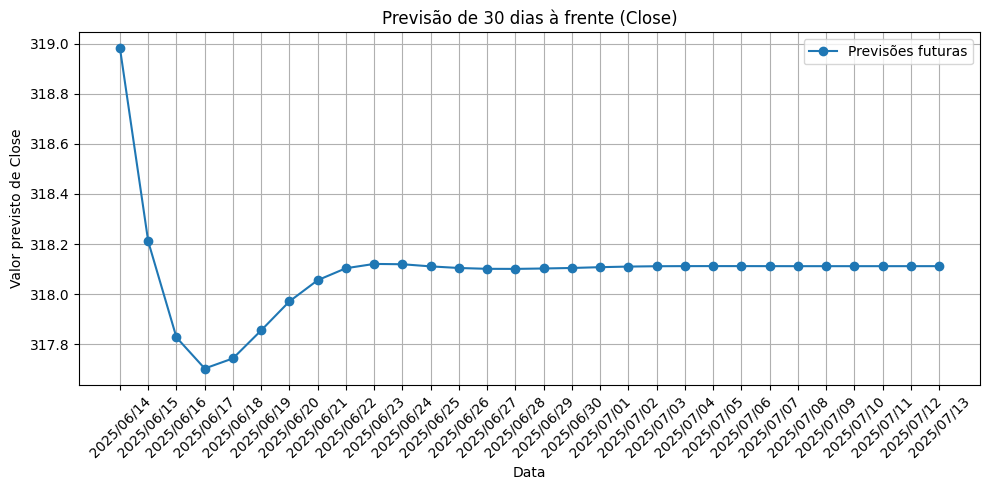

In [56]:
plt.figure(figsize=(10, 5))
plt.plot(future_dates, multi_preds_descaled, marker='o', label="Previsões futuras")
plt.title(f"Previsão de {steps_ahead} dias à frente (Close)")
plt.xlabel("Data")
plt.ylabel("Valor previsto de Close")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### Salvando o modelo

In [58]:
torch.save(melhor_modelo.state_dict(), "modelo_lstm_v2.pth")

### Carregando o modelo salvo

In [61]:
model_loaded = LSTMAtivacao(
    input_size=input_size,
    hidden_size=hidden_size,
    num_layers=num_layers,
    output_size=output_size,
    ativacao=ativacoes[melhor_ativacao]  # 👈 usa o dicionário diretamente
).to(device)

model_loaded.load_state_dict(torch.load("modelo_lstm_v2.pth"))
model_loaded.eval()

LSTMAtivacao(
  (lstm): LSTM(11, 50, num_layers=2, batch_first=True)
  (regressor): Sequential(
    (0): ReLU()
    (1): Linear(in_features=50, out_features=1, bias=True)
  )
)